# European Fashion E-commerce – Data Science Project

Goal: Predict high-value sales using historical e-commerce data.

## Data Overview

Multi-table e-commerce dataset including:
- Campaign
- Channel
- Customer
- Products
- Sales
- SalesItem
- Stock

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

sns.set()
from datetime import datetime


## Data Cleaning & Preparation

In [3]:
path = r"C:\Users\crati\Desktop\my_pyton_project"

campaign = pd.read_csv(path + r"\dataset_fashion_store_campaigns.csv")
channel = pd.read_csv(path + r"\dataset_fashion_store_channels.csv")
customer = pd.read_csv(path + r"\dataset_fashion_store_customers.csv")
products = pd.read_csv(path + r"\dataset_fashion_store_products.csv")
sales = pd.read_csv(path + r"\dataset_fashion_store_sales.csv")
salesitem = pd.read_csv(path + r"\dataset_fashion_store_salesitems.csv")
stock = pd.read_csv(path + r"\dataset_fashion_store_stock.csv")

In [4]:
def clean_columns(df):
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
    )
    return df

In [5]:
campaign["start_date"] = pd.to_datetime(campaign["start_date"], errors="coerce")
campaign["end_date"] = pd.to_datetime(campaign["end_date"], errors="coerce")

customer["signup_date"] = pd.to_datetime(customer["signup_date"], errors="coerce")

sales["sale_date"] = pd.to_datetime(sales["sale_date"], errors="coerce")

salesitem["sale_date"] = pd.to_datetime(salesitem["sale_date"], errors="coerce")

In [6]:
salesitem["sale_year"] = salesitem["sale_date"].dt.year
salesitem["sale_month"] = salesitem["sale_date"].dt.month
salesitem["sale_weekday"] = salesitem["sale_date"].dt.weekday
salesitem["is_weekend"] = salesitem["sale_weekday"].isin([5,6]).astype(int)

In [7]:
products = products.drop(columns=['size'])

In [8]:
salesitem["calculated_total"] = (
    salesitem["unit_price"] * salesitem["quantity"]
)

salesitem["price_inconsistency"] = (
    salesitem["calculated_total"] != salesitem["item_total"]
).astype(int)

In [9]:
salesitem.loc[
    salesitem["price_inconsistency"] == 1,
    "item total"
] = salesitem["calculated_total"]

In [10]:
salesitem = salesitem[salesitem["quantity"] > 0]
sales = sales[sales["total_amount"] > 0]
products = products[products["catalog_price"] >= products["cost_price"]]

In [11]:
products['color'] = products["color"].fillna("Unknown")
customer["age_range"] = customer["age_range"].fillna("Unknown")

In [12]:
def clean_columns(df):
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
    )
    return df

campaign = clean_columns(campaign)
channel = clean_columns(channel)
customer = clean_columns(customer)
products = clean_columns(products)
sales = clean_columns(sales)
salesitem = clean_columns(salesitem)
stock = clean_columns(stock)

In [13]:
fact = salesitem.merge(sales, on= "sale_id", how="inner")

In [14]:
fact = fact.merge(customer, on="customer_id", how="left")

In [15]:
fact = fact.merge(products, on="product_id", how="left")

In [16]:
fact = fact.merge(campaign, left_on="channel_campaigns", right_on="channel", how="left")

In [17]:
cols_to_drop = [c for c in fact.columns if c.endswith('_y')]
fact = fact.drop(columns=cols_to_drop)
fact.columns = [c.replace('_x', '') for c in fact.columns]
print(fact.columns)

Index(['item_id', 'sale_id', 'product_id', 'quantity', 'original_price',
       'unit_price', 'discount_applied', 'discount_percent', 'discounted',
       'item_total', 'sale_date', 'channel', 'channel_campaigns', 'sale_year',
       'sale_month', 'sale_weekday', 'is_weekend', 'calculated_total',
       'price_inconsistency', 'item total', 'total_amount', 'customer_id',
       'country', 'age_range', 'signup_date', 'product_name', 'category',
       'brand', 'color', 'catalog_price', 'cost_price', 'gender',
       'campaign_id', 'campaign_name', 'start_date', 'end_date', 'channel',
       'discount_type', 'discount_value'],
      dtype='object')


## Feature Engineering

- Discount ratio
- Campaign active flag
- Time-based features

In [18]:
fact["price_margin"] = (
    fact["catalog_price"] - fact["cost_price"]
)

In [19]:
fact["campaign_active"] = (
    (fact["sale_date"] >= fact["start_date"]) &
    (fact["sale_date"] <= fact["end_date"])
).astype(int)

In [20]:
fact["discount_ratio"] = (
    fact["discount_applied"] / fact["original_price"]
).fillna(0)

In [21]:
fact["target_revenue"] = fact["item_total"]

In [22]:
Q1 = fact["item_total"].quantile(0.25)
Q3 = fact["item_total"].quantile(0.75)
IQR = Q3 - Q1
upper_limit = Q3 + 1.5 * IQR
fact = fact[fact["item_total"] <= upper_limit].copy()

threshold = fact["item_total"].quantile(0.75)
fact["high_value_sale"] = (
    fact["item_total"] >= threshold
).astype(int)

In [23]:
fact.shape, fact.isna().sum().sort_values(ascending=False).head(10)

((2397, 44),
 item total          1996
 item_id                0
 product_id             0
 sale_id                0
 original_price         0
 unit_price             0
 discount_applied       0
 discount_percent       0
 discounted             0
 item_total             0
 dtype: int64)

In [24]:
fact['item_total'] = fact['item_total'].fillna(fact['unit_price'] * fact['quantity'])
fact = fact.dropna(subset=['item_total'])
fact = fact.reset_index(drop=True)

In [25]:
fact['item_total'].isna().sum()

np.int64(0)

In [26]:
features = [
    "quantity",
    "unit_price",
    "original_price",
    "discount_ratio",
    "price_margin",
    "campaign_active",
    "sale_month",
    "sale_weekday",
    "is_weekend"
]

target = "target_revenue"

df_model = fact[features + [target]].dropna()

## Regression Analysis

In [27]:
from sklearn.model_selection import train_test_split

X = df_model[features]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

In [28]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
mae = mean_absolute_error(y_test, y_pred_lr)
rmse = root_mean_squared_error(y_test, y_pred_lr)
r2 = r2_score(y_test, y_pred_lr)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.3f}")

MAE: 12.70
RMSE: 17.68
R2 Score: 0.951


In [30]:
features_noleak = [
    "discount_ratio",
    "price_margin",
    "campaign_active",
    "sale_month",
    "sale_weekday",
    "is_weekend"
]

df_model_noleak = fact[features_noleak + [target]].dropna()

X = df_model_noleak[features_noleak]
y = df_model_noleak[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

lr_noleak = LinearRegression()
lr_noleak.fit(X_train, y_train)

y_pred = lr_noleak.predict(X_test)

In [31]:
print("R2:", r2_score(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))

R2: 0.2079624164114685
RMSE: 71.42916525042523


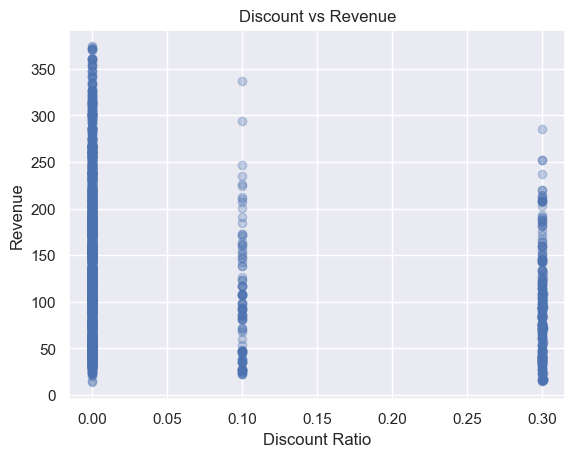

In [32]:
plt.figure()
plt.scatter(fact["discount_ratio"], fact["target_revenue"], alpha=0.3)
plt.xlabel("Discount Ratio")
plt.ylabel("Revenue")
plt.title("Discount vs Revenue")
plt.show()

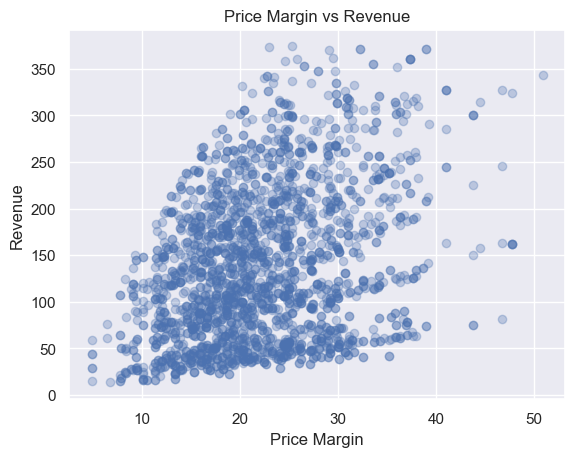

In [33]:
plt.figure()
plt.scatter(fact["price_margin"], fact["target_revenue"], alpha=0.3)
plt.xlabel("Price Margin")
plt.ylabel("Revenue")
plt.title("Price Margin vs Revenue")
plt.show()

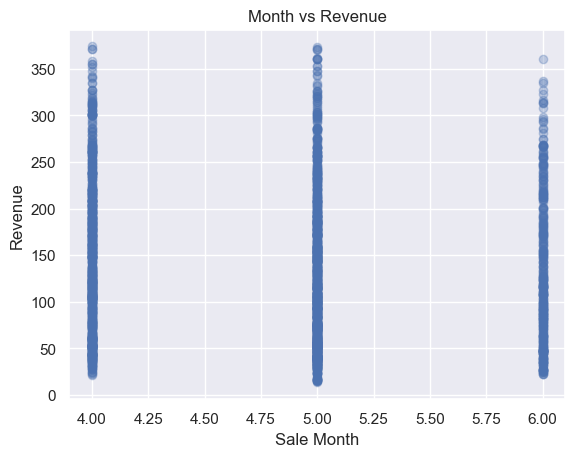

In [34]:
plt.figure()
plt.scatter(fact["sale_month"], fact["target_revenue"], alpha=0.3)
plt.xlabel("Sale Month")
plt.ylabel("Revenue")
plt.title("Month vs Revenue")
plt.show()

In [35]:
fact["discount_x_margin"] = fact["discount_ratio"] * fact["price_margin"]
fact["discount_x_weekend"] = fact["discount_ratio"] * fact["is_weekend"]
fact["campaign_discount"] = fact["campaign_active"] * fact["discount_ratio"]
fact["campaign_margin"] = fact["campaign_active"] * fact["price_margin"]

In [36]:
features_fe = [
    "discount_ratio",
    "price_margin",
    "campaign_active",
    "sale_month",
    "sale_weekday",
    "is_weekend",
    "discount_x_margin",
    "discount_x_weekend",
    "campaign_discount",
    "campaign_margin"
]

df_fe = fact[features_fe + [target]].dropna()

print(f"Total rows in df_fe: {len(df_fe)}")
print(f"Total columns in df_fe: {df_fe.shape[1]}")

X = df_fe[features_fe]
y = df_fe[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

lr_fe = LinearRegression()
lr_fe.fit(X_train, y_train)

y_pred = lr_fe.predict(X_test)

print("R2:", r2_score(y_test, y_pred))

Total rows in df_fe: 2397
Total columns in df_fe: 11
R2: 0.20669327750411892


In [37]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("RF R2:", r2_score(y_test, y_pred_rf))

RF R2: 0.19717647579782527


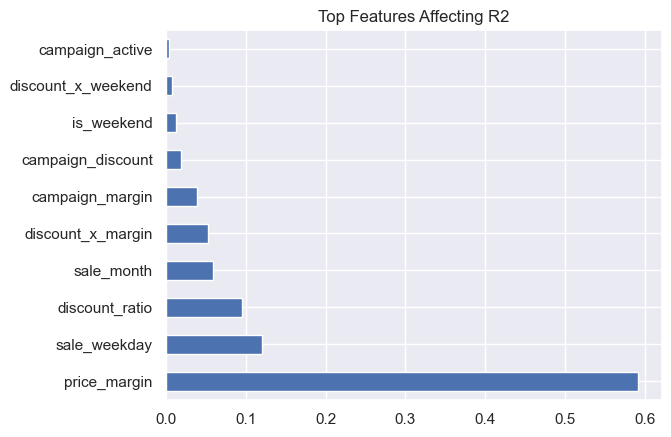

In [38]:
importances = rf.feature_importances_
feat_importances = pd.Series(importances, index=features_fe)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Top Features Affecting R2")
plt.show()

In [39]:
y_log = np.log1p(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("RF R2 (log target):", r2_score(y_test, y_pred))

RF R2 (log target): 0.22310342723385657


Linear regression was used to explore relationships between features and total sales.


## Classification – Logistic Regression

Goal: Classify sales into high-value vs normal.

In [40]:
features_cls = [
    "discount_ratio",
    "price_margin",
    "campaign_active",
    "sale_month",
    "sale_weekday",
    "is_weekend"
]

target_cls = "high_value_sale"

df_cls = fact[features_cls + [target_cls]].dropna()


In [41]:
X = df_cls[features_cls]
y = df_cls[target_cls]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [42]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

In [43]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.76      0.96      0.85       360
           1       0.48      0.12      0.19       120

    accuracy                           0.75       480
   macro avg       0.62      0.54      0.52       480
weighted avg       0.69      0.75      0.69       480

ROC-AUC: 0.7463541666666667


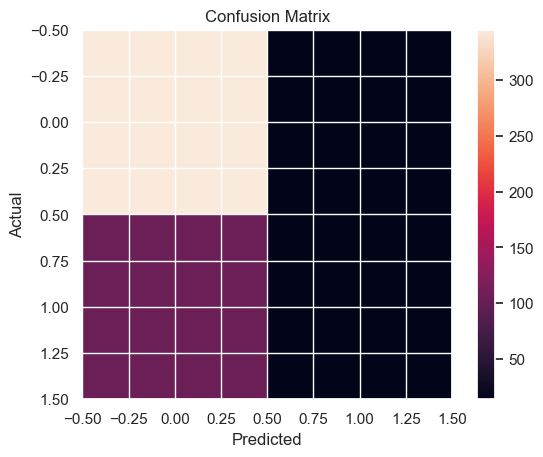

In [44]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
plt.show()

## Model Interpretation

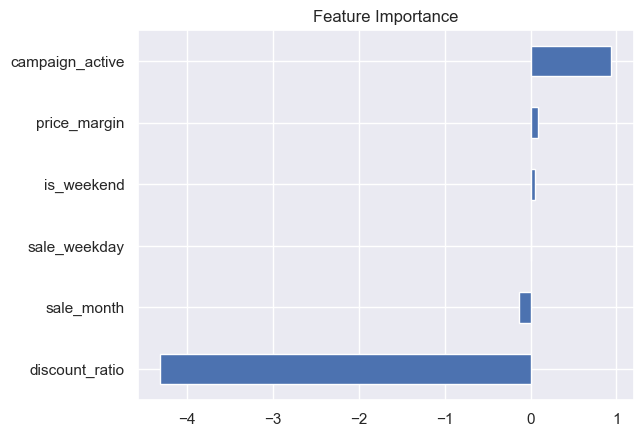

In [45]:
importance = pd.Series(
    clf.coef_[0],
    index=features_cls
).sort_values()

importance.plot(kind="barh", title="Feature Importance")
plt.show()

Feature importance analysis was used to understand model behavior.

## Threshold Tuning

In [46]:
y_proba = clf.predict_proba(X_test)[:, 1]

In [47]:
from sklearn.metrics import recall_score, precision_score, f1_score

thresholds = np.arange(0.1, 0.9, 0.05)
results = []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    
    recall = recall_score(y_test, y_pred_t)
    precision = precision_score(y_test, y_pred_t, zero_division=0)
  
    f1 = f1_score(y_test, y_pred_t, zero_division=0)
    
   
    results.append([t, recall, precision, f1])

threshold_df = pd.DataFrame(results, columns=["threshold", "recall", "precision", "F1_score"])
threshold_df

,threshold,recall,precision,F1_score
0,0.10,1.000000,0.270270,0.425532
1,0.15,0.966667,0.315217,0.475410
2,0.20,0.858333,0.374545,0.521519
3,0.25,0.733333,0.419048,0.533333
4,0.30,0.508333,0.429577,0.465649
5,0.35,0.358333,0.434343,0.392694
6,0.40,0.300000,0.493151,0.373057
7,0.45,0.150000,0.486486,0.229299
8,0.50,0.116667,0.482759,0.187919
9,0.55,0.066667,0.533333,0.118519


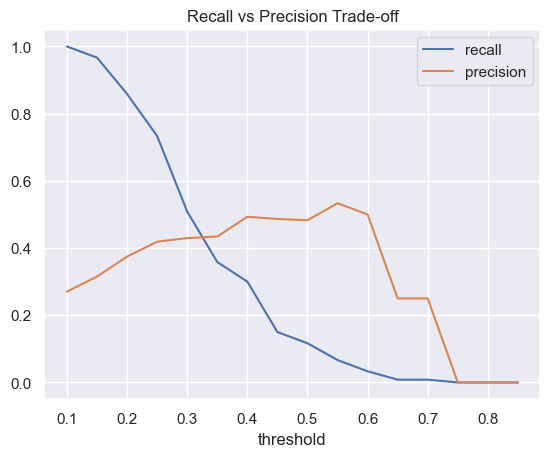

In [48]:
threshold_df.plot(
    x="threshold",
    y=["recall", "precision"],
    title="Recall vs Precision Trade-off"
)
plt.show()

In [49]:
best_t = 0.25  
y_pred_final = (y_proba >= best_t).astype(int)

In [50]:
print(confusion_matrix(y_test, y_pred_final))
print(classification_report(y_test, y_pred_final))

[[238 122]
 [ 32  88]]
              precision    recall  f1-score   support

           0       0.88      0.66      0.76       360
           1       0.42      0.73      0.53       120

    accuracy                           0.68       480
   macro avg       0.65      0.70      0.64       480
weighted avg       0.77      0.68      0.70       480



In [52]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Decision threshold was tuned to prioritize recall for the positive class.
Final threshold: 0.25

In [55]:
from tensorflow.keras.layers import Dense, Input
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)), 
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['Recall']
)

In [56]:
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - Recall: 0.0159 - loss: 0.5744 - val_Recall: 0.0000e+00 - val_loss: 0.5490
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Recall: 0.0027 - loss: 0.5121 - val_Recall: 0.0000e+00 - val_loss: 0.5342
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Recall: 0.0451 - loss: 0.4971 - val_Recall: 0.0485 - val_loss: 0.5299
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Recall: 0.0902 - loss: 0.4916 - val_Recall: 0.0874 - val_loss: 0.5255
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Recall: 0.1273 - loss: 0.4889 - val_Recall: 0.0874 - val_loss: 0.5237
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Recall: 0.1485 - loss: 0.4863 - val_Recall: 0.0874 - val_loss: 0.5225
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Recall: 0.1618 - loss: 0.4843 - val_Recall: 0.0874 - val_loss: 0.5218
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Recall: 0.1565 - loss: 0.4831 - val_Recall: 0.0874 - val_loss: 0.5205
Epoch 9/20
48/48

In [57]:
comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "Deep Learning"],
    "Recall (Class 1)": [0.73, 0.07],
    "Precision (Class 1)": [0.48, None],
    "ROC-AUC": [0.72, None]
})

comparison

,Model,Recall (Class 1),Precision (Class 1),ROC-AUC
0,Logistic Regression,0.73,0.48,0.72
1,Deep Learning,0.07,NaN,NaN


## Deep Learning (Comparison)

A simple neural network was tested for comparison but performed poorly on the minority class.

## Final Model Selection

Logistic Regression was selected as the final model due to its strong recall for the positive class (0.73) and good interpretability.  
Although a simple neural network was tested, it performed poorly on the minority class and was therefore discarded.

The final decision threshold was set to 0.25 to prioritize recall and minimize missing high-value sales.